In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/created-model-overnight-500-epochs/data_list.pth
/kaggle/input/created-model-overnight-500-epochs/gcn_model (1).pkl
/kaggle/input/created-model-overnight-500-epochs/output.csv
/kaggle/input/top-100-descriptors-rfe/output.csv


In [3]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 647.1 kB/s eta 0:00:00 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.4 MB/s eta 0:00:00a 0:00:01


In [4]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool

In [5]:
# Load the dataset
df = pd.read_csv('/kaggle/input/created-model-overnight-500-epochs/output.csv')


In [6]:
df

,SMILES,SMR_VSA3.1,SMR_VSA3,SsssN,AATS2i,MolLogP,PEOE_VSA1,PEOE_VSA1.1,AATS1i,SssNH,...,FractionCSP3,IC3,GATS2p,ATS4p,ZMIC4,VSA_EState7,GATS1se,ATS3Z,GATS1are,drug_like
0,COc1ccc(c2c1cc(C)cc2O)OC,0.0,0.0,0.0,153.239088,2.87102,14.582534,14.580253,144.000849,0.0,...,0.230769,3.964735,0.668026,93.875829,22.640684,0.000000,0.930320,1255,0.872852,0
1,O=C1C[C@@H]2[C@]([C@@H]3C1=CC(=CC3)C(C)C)(C)CC...,0.0,0.0,0.0,149.746256,4.38520,5.108808,5.106527,142.811300,0.0,...,0.700000,4.946552,1.000069,253.611866,23.002047,-24.913513,0.647909,2390,0.678725,0
2,BrC(C(=O)O)Br,0.0,0.0,0.0,152.530134,1.18690,5.108808,5.106527,148.263100,0.0,...,0.500000,2.750000,0.907447,4.512050,46.250000,0.000000,1.167441,1150,1.050826,0
3,COc1c(O)cc(cc1O)[C@H]1Oc2c(C[C@@H]1O)c(O)cc1c2...,0.0,0.0,0.0,149.177154,3.00430,44.491493,44.480089,144.979838,0.0,...,0.269231,5.348394,0.968097,234.502138,27.389683,-16.408030,0.975596,3381,0.925758,0
4,CC(=O)OC[C@H]1O[C@@H](OC[C@H]2O[C@@H](OC(=O)[C...,0.0,0.0,0.0,153.528940,-0.65790,98.828657,98.803568,147.004107,0.0,...,0.886792,6.088397,1.185811,716.561305,33.184803,-185.114013,0.949537,8792,0.902046,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4174,[Na+].O[S]([O-])=O,0.0,0.0,0.0,174.308466,-3.65750,9.107781,9.105500,152.108420,0.0,...,0.000000,2.584963,0.007064,0.000000,22.403008,0.000000,0.222524,16,0.621014,1
4175,[Na+].[Na+].[Na+].[O-]B([O-])[O-],0.0,0.0,0.0,185.451286,-12.93580,15.072068,15.072068,113.002851,0.0,...,0.000000,1.448816,0.000000,0.000000,31.866554,0.000000,0.396631,0,0.712210,1
4176,[Na+].CC1(C)C2CCC1(C[S]([O-])(=O)=O)C(=O)C2,0.0,0.0,0.0,150.818654,-2.06900,4.552750,4.552750,141.445990,0.0,...,0.900000,4.066784,0.017505,130.422733,26.638084,-12.921227,0.153352,1530,0.372388,1
4177,[Na+].[Na+].[O-]C([O-])=O,0.0,0.0,0.0,185.451286,-8.43900,15.007592,15.007592,153.343328,0.0,...,0.000000,1.918296,0.000000,0.000000,26.107771,-2.333333,0.178025,0,0.336015,1


In [7]:
smiles = df['SMILES'].tolist()


In [9]:
# Assuming your DataFrame is named 'df'
headers = list(df.columns)[1:-1]

In [10]:
headers

['SMR_VSA3.1',
 'SMR_VSA3',
 'SsssN',
 'AATS2i',
 'MolLogP',
 'PEOE_VSA1',
 'PEOE_VSA1.1',
 'AATS1i',
 'SssNH',
 'SlogP_VSA7',
 'SlogP_VSA2.1',
 'MinAbsEStateIndex',
 'SlogP_VSA2',
 'ATSC1i',
 'IC2',
 'SMR_VSA6.1',
 'NsssN',
 'SLogP',
 'SlogP_VSA1',
 'qed',
 'SlogP_VSA1.1',
 'Radius',
 'VSA_EState8',
 'BalabanJ',
 'AATSC0i',
 'TIC1',
 'AATS2v',
 'WPath',
 'ATS3p',
 'FCSP3',
 'TopoShapeIndex',
 'NssNH',
 'BalabanJ.1',
 'Xp-4dv',
 'MATS1i',
 'VSA_EState3',
 'SMR_VSA6',
 'AATSC1i',
 'ATSC1pe',
 'ExactMolWt',
 'AATS2p',
 'ATS4se',
 'FilterItLogS',
 'IC1',
 'ATS2v',
 'Xp-1dv',
 'AATSC1are',
 'MIC0',
 'VSA_EState8.1',
 'AATS0i',
 'VSA_EState4.1',
 'MATS1pe',
 'AATSC0Z',
 'PetitjeanIndex',
 'ATSC0i',
 'NHOHCount',
 'AATS1v',
 'piPC6',
 'ATS3m',
 'Mi',
 'ATS3i',
 'AATSC0are',
 'MATS2v',
 'AATSC1pe',
 'MATS2Z',
 'Chi1v',
 'MATS1se',
 'AXp-2d',
 'ATSC1are',
 'SdssC',
 'IC0',
 'Xpc-4dv',
 'ATSC3i',
 'AATSC0p',
 'BIC2',
 'AATSC2m',
 'MolWt',
 'Xp-3dv',
 'ATSC4v',
 'SsssCH',
 'ATS4pe',
 'NssO',
 'M

In [11]:
features = df[headers].values # Replace with your feature columns

In [12]:
# features = df[['feature1', 'feature2', 'feature3']].values  # Replace with your feature columns
target = df['drug_like'].values


In [13]:
target

array([0, 0, 0, ..., 1, 1, 1])

In [14]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 45.5 MB/s eta 0:00:00:00:0100:01


In [15]:
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.data import Data

In [14]:
# def mol_to_graph(smiles, features):
#     mol = Chem.MolFromSmiles(smiles)
#     mol = Chem.AddHs(mol)
#     AllChem.EmbedMolecule(mol)
#     AllChem.MMFFOptimizeMolecule(mol)

#     # Get node features
#     atom_features = []
#     for atom in mol.GetAtoms():
#         atom_feature = [atom.GetAtomicNum(), atom.GetFormalCharge()]
#         atom_feature.extend(features)  # Include additional feature variables
#         atom_features.append(atom_feature)

#     # Get edge indices
#     edge_indices = []
#     for bond in mol.GetBonds():
#         start_idx = bond.GetBeginAtomIdx()
#         end_idx = bond.GetEndAtomIdx()
#         edge_indices.extend([(start_idx, end_idx), (end_idx, start_idx)])

#     x = torch.tensor(atom_features, dtype=torch.float)
#     edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

#     # Create a PyTorch Geometric Data object
#     data = Data(x=x, edge_index=edge_index)

#     return data

In [16]:
nan_count_per_column = df.isna().sum()
print("Number of NaN values in each column:")
print(nan_count_per_column)

Number of NaN values in each column:
SMILES          0
SMR_VSA3.1      0
SMR_VSA3        0
SsssN           0
AATS2i         46
               ..
VSA_EState7     0
GATS1se        63
ATS3Z           0
GATS1are       40
drug_like       0
Length: 102, dtype: int64


In [17]:
# Select all columns except the first one
columns_to_fill = df.columns[1:]

# Fill NaN values with the mean for these columns
df[columns_to_fill] = df[columns_to_fill].apply(lambda x: x.fillna(x.mean()), axis=0)

# Print the DataFrame to verify the changes
print(df)

                                                 SMILES  SMR_VSA3.1  SMR_VSA3  \
0                              COc1ccc(c2c1cc(C)cc2O)OC         0.0       0.0   
1     O=C1C[C@@H]2[C@]([C@@H]3C1=CC(=CC3)C(C)C)(C)CC...         0.0       0.0   
2                                         BrC(C(=O)O)Br         0.0       0.0   
3     COc1c(O)cc(cc1O)[C@H]1Oc2c(C[C@@H]1O)c(O)cc1c2...         0.0       0.0   
4     CC(=O)OC[C@H]1O[C@@H](OC[C@H]2O[C@@H](OC(=O)[C...         0.0       0.0   
...                                                 ...         ...       ...   
4174                                 [Na+].O[S]([O-])=O         0.0       0.0   
4175                  [Na+].[Na+].[Na+].[O-]B([O-])[O-]         0.0       0.0   
4176        [Na+].CC1(C)C2CCC1(C[S]([O-])(=O)=O)C(=O)C2         0.0       0.0   
4177                          [Na+].[Na+].[O-]C([O-])=O         0.0       0.0   
4178                                        [Na+].[Cl-]         0.0       0.0   

      SsssN      AATS2i   M

In [18]:
def mol_to_graph(smiles, features):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    try:
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol)
    except:
        pass

    # Get node features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_feature = [atom.GetAtomicNum(), atom.GetFormalCharge()]
        atom_feature.extend(features)  # Include additional feature variables
        atom_features.append(atom_feature)

    # Get edge indices
    edge_indices = []
    for bond in mol.GetBonds():
        start_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        edge_indices.extend([(start_idx, end_idx), (end_idx, start_idx)])

    x = torch.tensor(atom_features, dtype=torch.float)
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    # Create a PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index)

    return data

In [19]:
# # Convert SMILES to molecular graphs
# graphs = [mol_to_graph(s, f) for s, f in zip(smiles, features)]

In [20]:
# graphs

In [21]:
!pip install torch torch-geometric

In [22]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


In [23]:
# # Load your DataFrame
# df = pd.read_csv('/kaggle/input/top-100-descriptors-rfe/output.csv')

# Extract the SMILES strings
smiles_list = df['SMILES'].tolist()

# Extract the feature variables
feature_columns = df.columns.difference(['SMILES', 'drug_like'])
feature_list = df[feature_columns].values.tolist()

In [24]:
smiles_list

['COc1ccc(c2c1cc(C)cc2O)OC',
 'O=C1C[C@@H]2[C@]([C@@H]3C1=CC(=CC3)C(C)C)(C)CCC[C@@]2(C)C(=O)O',
 'BrC(C(=O)O)Br',
 'COc1c(O)cc(cc1O)[C@H]1Oc2c(C[C@@H]1O)c(O)cc1c2[C@H](CC(=O)O1)c1ccc(c(c1)OC)O',
 'CC(=O)OC[C@H]1O[C@@H](OC[C@H]2O[C@@H](OC(=O)[C@@]34CCC(=C)C[C@H]4C4=CC[C@H]5[C@H]([C@@]4(CC3)C)CC[C@@H]3[C@]5(C)CC[C@@H](C3(C)C)O[C@@H]3OC[C@@H]([C@@H]([C@H]3O)O)O)[C@@H]([C@H]([C@@H]2O)O)O)[C@@H]([C@H]([C@@H]1O[C@@H]1O[C@@H](C)[C@@H]([C@H]([C@H]1O)O)O)O)O',
 'O=C(/C=C/c1ccccc1)OCc1ccccc1',
 'COc1cc2oc(cc(=O)c2c(c1OC)O)c1ccc(cc1)O',
 'C1CCC2C(C1)CCCC2',
 'COc1ccc2c(c1)[nH]c1c2cc(c(c1)OC)O',
 'COc1cc(ccc1O)c1coc2c(c1=O)ccc(c2)O',
 'BrC(CCC[C@H]1CCCC[C@H](C)[C@@H](O)c2cc(O)c(c(c2)O)[C@H](CCCC[C@@H]([C@H](c2cc(c1c(O)c2)O)O)C)CCCC(Br)Br)Br',
 'CC(=O)/C=C/C1C(=CCCC1(C)C)C',
 'CC(=CCC[C@]1(C)[C@@H](CC=C(C)C)C[C@]23C(=O)[C@@]1(C(=O)C(=C3O[C@@H](C2)C(O)(C)C)CC=C(C)C)C(=O)c1ccccc1)C',
 'OC[C@H]1CC[C@H]2[C@@]31CC[C@H](C3)C(C2=C)(C)C',
 'CC(=O)O[C@@H]1C[C@@H]2C(C)(C)CCC[C@@]2(C)C(=O)[C@H](C[C@@H]2C=C1C(

In [25]:
# Extract the target labels (last column)
targets = df['drug_like'].tolist()

In [26]:
len(targets)

4179

### If you already have the data_list.pth file.. you can skip the below code block and run the code block that is below it.

In [ ]:
from torch_geometric.data import Data, DataLoader

# Assuming `smiles` is your list of SMILES strings and `features` is your list of feature lists
# `targets` should be your list of target labels (0 or 1)
data_list = []
for smiles, feature, target in zip(smiles_list, feature_list, targets):
    graph = mol_to_graph(smiles, feature)
    graph.y = torch.tensor([target], dtype=torch.long)
    data_list.append(graph)


In [27]:
# Load the data_list from the .pth file
data_list = torch.load('/kaggle/input/created-model-overnight-500-epochs/data_list.pth')


In [28]:
data_list

[Data(x=[30, 102], edge_index=[2, 62], y=[1]),
 Data(x=[51, 102], edge_index=[2, 106], y=[1]),
 Data(x=[8, 102], edge_index=[2, 14], y=[1]),
 Data(x=[60, 102], edge_index=[2, 128], y=[1]),
 Data(x=[157, 102], edge_index=[2, 330], y=[1]),
 Data(x=[32, 102], edge_index=[2, 66], y=[1]),
 Data(x=[37, 102], edge_index=[2, 78], y=[1]),
 Data(x=[28, 102], edge_index=[2, 58], y=[1]),
 Data(x=[31, 102], edge_index=[2, 66], y=[1]),
 Data(x=[33, 102], edge_index=[2, 70], y=[1]),
 Data(x=[98, 102], edge_index=[2, 200], y=[1]),
 Data(x=[34, 102], edge_index=[2, 68], y=[1]),
 Data(x=[93, 102], edge_index=[2, 192], y=[1]),
 Data(x=[40, 102], edge_index=[2, 84], y=[1]),
 Data(x=[62, 102], edge_index=[2, 128], y=[1]),
 Data(x=[52, 102], edge_index=[2, 108], y=[1]),
 Data(x=[41, 102], edge_index=[2, 86], y=[1]),
 Data(x=[51, 102], edge_index=[2, 104], y=[1]),
 Data(x=[49, 102], edge_index=[2, 104], y=[1]),
 Data(x=[122, 102], edge_index=[2, 246], y=[1]),
 Data(x=[41, 102], edge_index=[2, 88], y=[1]),
 D

In [29]:
print(f"Total number of graphs: {len(data_list)}")

Total number of graphs: 4179


In [30]:
from torch_geometric.loader import DataLoader



In [31]:
# Create a DataLoader
train_loader = DataLoader(data_list, batch_size=32, shuffle=True)

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
# Assuming data_list is your list of graph data
train_data_list, test_data_list = train_test_split(data_list, test_size=0.2, random_state=42)

In [34]:
# Define batch size
batch_size = 32

# Create DataLoader for training set
train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=True)

# Create DataLoader for testing set
test_loader = DataLoader(test_data_list, batch_size=batch_size, shuffle=False)

In [35]:
# Check the sizes of the splits
print(f"Number of training graphs: {len(train_data_list)}")
print(f"Number of testing graphs: {len(test_data_list)}")

Number of training graphs: 3343
Number of testing graphs: 836


In [36]:
# Check if GPU is available and use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
device

device(type='cuda')

In [38]:
import torch

# Assuming `data_list` is your list of Data objects
torch.save(data_list, 'data_list.pth')

In [39]:
# Move data to the GPU
data_list = [data.to(device) for data in data_list]


In [40]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GraphConv
import torch
import torch.nn.functional as F

In [41]:
from torch_geometric.nn import GraphConv, global_mean_pool

In [42]:
class GraphConvNet(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GraphConvNet, self).__init__()
        self.conv1 = GraphConv(num_node_features, 64)
        self.conv2 = GraphConv(64, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [43]:
# # Instantiate the model and move it to the GPU
# model = GraphConvNet(num_node_features=102, num_classes=2).to(device)


In [44]:
class ImprovedGraphConvNet(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(ImprovedGraphConvNet, self).__init__()
        self.conv1 = GraphConv(num_node_features, 64)
        self.bn1 = BatchNorm(64)
        self.conv2 = GraphConv(64, 128)
        self.bn2 = BatchNorm(128)
        self.conv3 = GraphConv(128, 128)
        self.bn3 = BatchNorm(128)
        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, num_classes)
        self.dropout = Dropout(0.5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [45]:
from torch_geometric.nn import GraphConv, BatchNorm
from torch.nn import Dropout
from torch_geometric.nn import global_mean_pool

In [46]:
# Initialize the model
num_node_features = 102  # Define the number of node features
num_classes = 2  # Define the number of classes
model = ImprovedGraphConvNet(num_node_features, num_classes)

In [47]:
# Define an optimizer and loss function with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [48]:

import pandas as pd

# Assuming `df` is your DataFrame
# Check for NaN values in the entire DataFrame
nan_values = df.isna().any().any()

# Check for NaN values in each column
nan_columns = df.columns[df.isna().any()].tolist()

# Check for NaN values in each row
nan_rows = df[df.isna().any(axis=1)]

if nan_values:
    print("NaN values detected in the DataFrame.")
    print("Columns with NaN values:", nan_columns)
    print("Rows with NaN values:")
    print(nan_rows)
else:
    print("No NaN values detected in the DataFrame.")

No NaN values detected in the DataFrame.


In [49]:
for data in data_list:
    if torch.isnan(data.x).any() or torch.isinf(data.x).any():
        print(f'Invalid values found in features for data: {data}')
    if torch.isnan(data.edge_index).any() or torch.isinf(data.edge_index).any():
        print(f'Invalid values found in edge_index for data: {data}')

In [50]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [51]:
data = data.to(device)

In [52]:
model = ImprovedGraphConvNet(num_node_features, num_classes).to(device)

In [53]:
# Training loop
model.train()
for epoch in range(200):  # Adjust the number of epochs as needed
    for data in train_loader:
        data = data.to(device)  # Move each batch to GPU
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.6711724996566772
Epoch 2, Loss: 0.7192798852920532
Epoch 3, Loss: 0.6586438417434692
Epoch 4, Loss: 0.729457437992096
Epoch 5, Loss: 0.7487548589706421
Epoch 6, Loss: 0.6994500756263733
Epoch 7, Loss: 0.7607736587524414
Epoch 8, Loss: 0.6694973111152649
Epoch 9, Loss: 0.8827326893806458
Epoch 10, Loss: 0.6782991886138916
Epoch 11, Loss: 0.744266927242279
Epoch 12, Loss: 0.7243839502334595
Epoch 13, Loss: 0.7034638524055481
Epoch 14, Loss: 0.7070260643959045
Epoch 15, Loss: 0.6982644200325012
Epoch 16, Loss: 0.6896364092826843
Epoch 17, Loss: 1.1508644819259644
Epoch 18, Loss: 0.6431916356086731
Epoch 19, Loss: 0.6879904270172119
Epoch 20, Loss: 0.6910697817802429
Epoch 21, Loss: 0.6829847693443298
Epoch 22, Loss: 0.7038926482200623
Epoch 23, Loss: 0.6998366117477417
Epoch 24, Loss: 0.7210426330566406
Epoch 25, Loss: 0.7100189924240112
Epoch 26, Loss: 0.7381772994995117
Epoch 27, Loss: 0.6889841556549072
Epoch 28, Loss: 0.6643518209457397
Epoch 29, Loss: 0.8047407865524

In [64]:
# Save the model's state_dict
torch.save(model.state_dict(), 'gcn_model_improved_graph_conv_state_dict.pth')


In [66]:
import torch

# Save the entire model
torch.save(model, 'gcn_model_improved_graph_conv.pth')

In [67]:
import torch
import pickle

# Assuming you have a trained model `model`
# Save the model's state_dict
state_dict = model.state_dict()

# Save the state_dict as a .pkl file using pickle
with open('gcn_model_improved_graph_conv.pkl', 'wb') as f:
    pickle.dump(state_dict, f)

In [68]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [69]:
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error

In [70]:
# Initialize variables for evaluation metrics
correct = 0
total = 0
precision = 0
recall = 0
f1 = 0
mse = 0
mae = 0

In [71]:
# Iterate over the test DataLoader
for data in test_loader:
    with torch.no_grad():
        # Move data to the device (GPU if available)
        data = data.to(device)
        
        # Forward pass
        outputs = model(data)
        
        # Get predicted labels
        _, predicted = torch.max(outputs, 1)
        
        # Calculate accuracy
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()
        
        # Calculate precision, recall, and F1 score
        precision += precision_score(data.y.cpu(), predicted.cpu(), average='macro')
        recall += recall_score(data.y.cpu(), predicted.cpu(), average='macro')
        f1 += f1_score(data.y.cpu(), predicted.cpu(), average='macro')
        
        # Calculate MSE and MAE
        mse += mean_squared_error(data.y.cpu(), predicted.cpu())
        mae += mean_absolute_error(data.y.cpu(), predicted.cpu())

In [72]:
# Calculate average accuracy
accuracy = correct / total

# Calculate average precision, recall, F1 score, MSE, and MAE
precision /= len(test_loader)
recall /= len(test_loader)
f1 /= len(test_loader)
mse /= len(test_loader)
mae /= len(test_loader)

In [73]:
# Print the evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

Accuracy: 0.5084
Precision: 0.4964
Recall: 0.4968
F1 Score: 0.4853
MSE: 0.5000
MAE: 0.5000


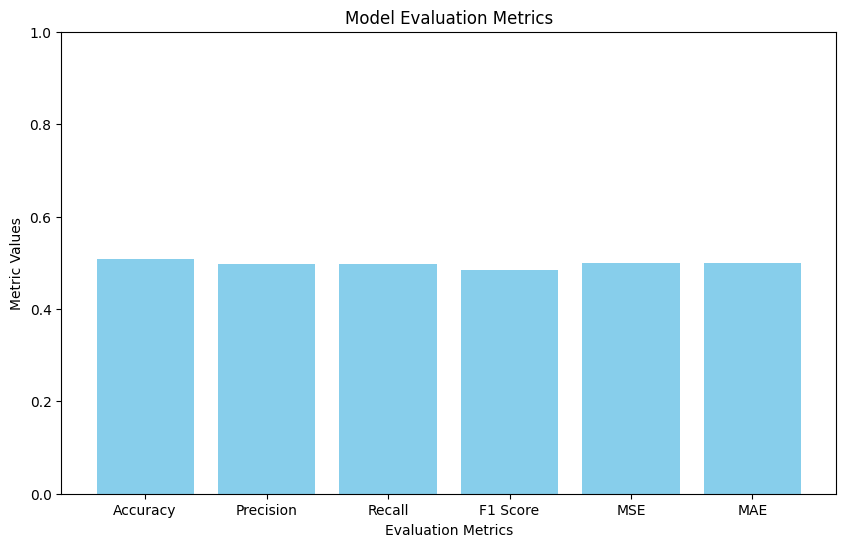

In [74]:
import matplotlib.pyplot as plt

# Evaluation metrics data
evaluation_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MSE', 'MAE']
metric_values = [accuracy, precision, recall, f1, mse, mae]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(evaluation_metrics, metric_values, color='skyblue')
plt.xlabel('Evaluation Metrics')
plt.ylabel('Metric Values')
plt.title('Model Evaluation Metrics')
plt.ylim(0, 1)  # Set y-axis limit for accuracy and other percentage metrics

# Save the plot as an image file
plt.savefig('evaluation_metrics_plot_1.png')

plt.show()


## **For Prediction**

In [59]:
import torch
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GraphConv, BatchNorm, global_mean_pool
import torch.nn.functional as F
from torch.nn import Dropout

In [60]:
# Define the GCN model architecture
class ImprovedGraphConvNet(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(ImprovedGraphConvNet, self).__init__()
        self.conv1 = GraphConv(num_node_features, 64)
        self.bn1 = BatchNorm(64)
        self.conv2 = GraphConv(64, 128)
        self.bn2 = BatchNorm(128)
        self.conv3 = GraphConv(128, 128)
        self.bn3 = BatchNorm(128)
        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, num_classes)
        self.dropout = Dropout(0.5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [61]:
# Define the function to convert SMILES strings to graph data
def mol_to_graph(smiles, num_node_features=102):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)

    # Get node features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_feature = [atom.GetAtomicNum(), atom.GetFormalCharge()]
        atom_feature += [0] * (num_node_features - 2)  # Placeholder features
        atom_features.append(atom_feature)

    # Get edge indices
    edge_indices = []
    for bond in mol.GetBonds():
        start_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        edge_indices.extend([(start_idx, end_idx), (end_idx, start_idx)])

    x = torch.tensor(atom_features, dtype=torch.float)
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    # Create a PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index)
    return data


In [62]:
# Load the pretrained model
model = ImprovedGraphConvNet(num_node_features=102, num_classes=2)

In [64]:
model_path = '/kaggle/working/gcn_model_improved_graph_conv_state_dict.pth'  # Update with your model's path

In [65]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [66]:
model.eval()

ImprovedGraphConvNet(
  (conv1): GraphConv(102, 64)
  (bn1): BatchNorm(64)
  (conv2): GraphConv(64, 128)
  (bn2): BatchNorm(128)
  (conv3): GraphConv(128, 128)
  (bn3): BatchNorm(128)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [87]:
smiles_list = ['C[C@@H]1O[C@H](CC[C@@H]1O[C@H]1C=CC(=O)[C@@H](O1)C)O[C@@]1(C)CC(=O)[C@]2([C@](C1)(O)C=CC1=C2C(=O)c2c(C1=O)c(O)c(cc2)[C@H]1C[C@@H](O)[C@@H]([C@H](O1)C)O[C@H]1CC[C@@H]([C@@H](O1)C)O)O', 'OC(=O)CC[C@@]1(C)[C@@H](CC[C@@]2([C@@H]1CC=C1[C@@]2(C)CC[C@@]2([C@H]1CC(C)(C)CC2)C(=O)O)C)C(O)(C)C','CO[C@H]1O[C@H](CC=C1CC/C=C(/CC/C=C(/CCC=C(C)C)\C)\C)[C@@H]1CC(=NC1=O)O' , 'CC(=O)O[C@@H]1C[C@]2(C)[C@H]3CC[C@]4([C@H](C3=CC[C@H]2[C@@H]([C@H]1O[C@@H]1O[C@@H](C)[C@@H]([C@H]([C@@H]1O)O)O)C)CC[C@@H]4[C@H](C(=O)S)CCC(=C)C(C)C)C']

In [88]:
# Convert SMILES to graph data
graph_data_list = [mol_to_graph(smiles, num_node_features=102) for smiles in smiles_list]

In [89]:
# Create a DataLoader
loader = DataLoader(graph_data_list, batch_size=32, shuffle=False)

In [90]:
predictions = []
with torch.no_grad():
    for data in loader:
        out = model(data)
        pred = out.argmax(dim=1)
        predictions.extend(pred.cpu().numpy())



In [91]:
print("Predictions:", predictions)

Predictions: [1, 1, 1, 1]


In [73]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [70]:
# Initialize variables for accuracy calculation
correct = 0
total = 0

# Iterate over the test DataLoader
for data in test_loader:
    with torch.no_grad():
        # Move data to the device (GPU if available)
        data = data.to(device)
        
        # Forward pass
        outputs = model(data)
        
        # Get predicted labels
        _, predicted = torch.max(outputs, 1)
        
        # Calculate accuracy
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()


In [71]:
# Calculate accuracy
accuracy = correct / total
print(f"Accuracy on the test set: {accuracy}")

Accuracy on the test set: 0.46172248803827753


In [ ]:
features

In [ ]:
model.eval()

In [ ]:
new_smiles = ['C[C@@H]1O[C@H](CC[C@@H]1O[C@H]1C=CC(=O)[C@@H](O1)C)O[C@@]1(C)CC(=O)[C@]2([C@](C1)(O)C=CC1=C2C(=O)c2c(C1=O)c(O)c(cc2)[C@H]1C[C@@H](O)[C@@H]([C@H](O1)C)O[C@H]1CC[C@@H]([C@@H](O1)C)O)O', 'OC(=O)CC[C@@]1(C)[C@@H](CC[C@@]2([C@@H]1CC=C1[C@@]2(C)CC[C@@]2([C@H]1CC(C)(C)CC2)C(=O)O)C)C(O)(C)C','CO[C@H]1O[C@H](CC=C1CC/C=C(/CC/C=C(/CCC=C(C)C)\C)\C)[C@@H]1CC(=NC1=O)O']

In [ ]:
test_data_list = []
for smiles in new_smiles:
    data = mol_to_graph(smiles, [])  # Pass an empty list for features since you don't have them
    test_data_list.append(data)

In [ ]:
from torch_geometric.data import Data, Batch  # Import the Batch class



In [ ]:
test_data = Batch.from_data_list(test_data_list)

In [ ]:
device

In [ ]:
test_data = test_data.to(device)

In [ ]:
train_data_list

In [ ]:
test_data_list

In [ ]:
with torch.no_grad():
    output = model(test_data)
    predictions = torch.argmax(output, dim=1)